# NAS Parallel Benchmarks Tests on Multiple CPUs (gem5-20.1)

This notebook shows results of running NAS parallel benchmarks with gem5art on multiple number of CPUs using KVM and timing cpu model of gem5. Only class A of NPB is used in these experiments. This experiment builds on a simpler test to run NPB with gem5art which is discussed in details [here](https://gem5art.readthedocs.io/en/latest/npb-tutorial.html).

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [2]:
#datadir = '/run/user/1000/gvfs/sftp:host=amarillo.cs.ucdavis.edu/fasthome/aakahlow/npb_tests/results/run_npb_multicore/'
datadir = '/data/Art-gem5/gem5-20-1-results/run_npb_multicore'

In [3]:
Benchmarks = sorted(os.listdir(datadir))
print(Benchmarks)

['bt.x', 'cg.x', 'ep.x', 'ft.x', 'is.x', 'lu.x', 'mg.x', 'sp.x']


In [4]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try: 
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except: #temporary change
        return 0.0

In [5]:
def getStatus(filename):
    out_file = os.path.join(datadir, '', filename, 'simout').replace('\\','/')
    err_file = os.path.join(datadir, '', filename, 'simerr').replace('\\','/')
    stat_file = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    sys_file = os.path.join(datadir, '', filename, 'system.pc.com_1.device').replace('\\','/')
    
    status = ''
    try: 
        with open(out_file) as f:
            l_line = f.readlines()[-1]
            if 'Total wallclock time:' in l_line:
                status = 'success'
            else:
                status = 'N/A'
    except: #temporary change
        status = 'N/A'

    try: 
        with open(err_file) as f:
            l_line = f.readlines()[-1]
            if '--- END LIBC BACKTRACE ---' in l_line:
                status = 'failure'
    except:
        status = 'N/A'    
    
    try:
        with open(stat_file) as f:
            for line in f:
                if '---------- Begin Simulation Statistics ----------' in line:
                    status = 'success'
    except:
        status = 'N/A'
    
    try:
        with open(sys_file) as f:
            l_line = f.readlines()[-1]
            if '---[ end Kernel panic' in l_line:
                status = 'kernel-panic'
    except:
        status = 'N/A'
                                                                                    
                                                                                     
    return status

In [6]:
Cpus = ['kvm','timing']
Cores_kvm = ['1', '8', '16', '32', '64']
Cores_timing = ['1', '8']#, '16', '32', '64'] 
Classes = ['A']

In [7]:
rows = []

for bm in Benchmarks:
    for clas in Classes:
        for cpu in Cpus:
            for core in Cores_kvm:                
                #if cpu == 'atomic' and clas != 'A':
                #    continue
                file_path = '{}/{}/{}/{}/{}/'.format(datadir,bm,clas,cpu,core)
                
                rows.append([bm,clas,cpu,core,
                     getStatus(file_path),
                     gem5GetStat(file_path, 'sim_ticks')/333, #1000
                     gem5GetStat(file_path, 'sim_insts')/1000000,
                     gem5GetStat(file_path, 'sim_ops'),
                     gem5GetStat(file_path, 'sim_seconds'),
                     gem5GetStat(file_path, 'host_seconds')/60])             


df = pd.DataFrame(rows, columns=['benchmark','class','cpu','core','status','cycles', 'instructions', 'ops', 'sim_time', 'host_time'])

df['host_hours'] = df['host_time']/60
df['ipc'] = df['instructions']/df['cycles']
df['cpi'] = df['cycles']/df['instructions']
df['opc'] = df['ops']/df['cycles']
                     
#print(df)

In [8]:
def print_host_time():
    fstat = open("npb_multicore_gem5art_stats.csv","w+")
    fstat.write("Benchmark,time_kvm,time_timing\n") #",instructions,syscalls,mem-accesses,loads,")
    #Coress = ['1']
    Coress = ['1', '8']#, '16', '32', '64'] 
    for core in Coress:
        fstat.write("core=%s class=A \n"% core)
        for bm in Benchmarks:
            fstat.write("%s,"% bm)
            d = df[(df['core']==core) & (df['cpu']=='kvm') & (df['benchmark']==bm) & (df['class']=='A')]
            time = d['host_time'].iloc[0]
            fstat.write("%f,"% time)
            d = df[(df['core']==core) & (df['cpu']=='timing') & (df['benchmark']==bm) & (df['class']=='A')]
            time = d['host_time'].iloc[0]
            fstat.write("%f,"% time)
            fstat.write("\n")        
        
    fstat.close()

In [9]:
print_host_time()

In [10]:
def doplot_status(cpu):
    if cpu == 'atomic':
        Classes_2_use = ['A']
    else:
        Classes_2_use = Classes
    plt.figure()
    i = 0
    barWidth = 1
    if cpu == 'kvm':
        Cores = Cores_kvm
    else:
        Cores = Cores_timing
    
    for bm in Benchmarks:
        for clas in Classes:
            for j,core in enumerate(Cores):
                d = df[(df['core']==core) & (df['cpu']==cpu) & (df['benchmark']==bm) & (df['class']==clas)]
                if d['status'].iloc[0] == 'success':
                    plt.bar(i, 1, bottom=j, color='C'+ str(2),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'N/A':
                    plt.bar(i, 1, bottom=j, color='C'+ str(1),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'failure':
                    plt.bar(i, 1, bottom=j, color='C'+ str(3),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'kernel-panic':
                    plt.bar(i, 1, bottom=j, color='C'+ str(4),edgecolor='white',width=barWidth)
            i = i+1
        i = i+1
    
    colours = ['C'+ str(1), 'C'+ str(3), 'C'+str(4), 'C'+ str(2)]#'R', 'Y']
    for i,cpu in enumerate(['timeout','failure', 'kernel-panic', 'success']):
        plt.bar(0,0,color=colours[i], label=cpu)
    
    plt.xticks(np.arange(len(Benchmarks))*2, Benchmarks, rotation=0, ha='left')

## Benchmark Working Status
The next plots show the status of working of NPB on gem5 with multiple number of CPUs. Each plot is drawn for a particular cpu (kvm and timing).

<IPython.core.display.Javascript object>


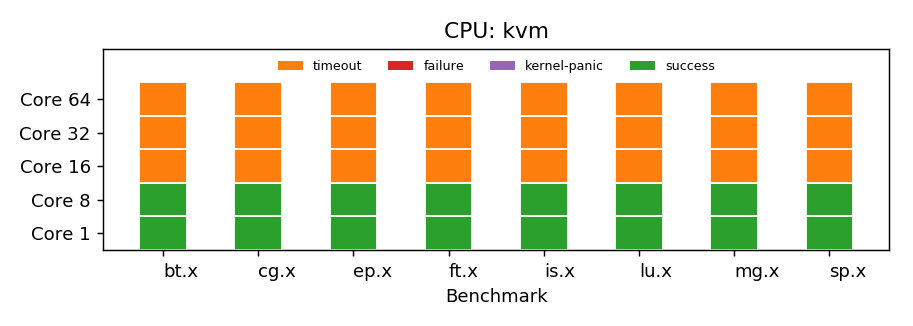

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


<IPython.core.display.Javascript object>


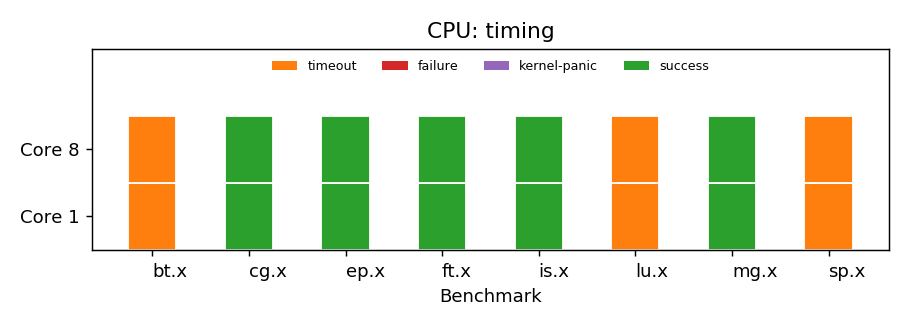

In [11]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_ty in ['kvm','timing']:
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 7
    fig_size[1] = 2.5
    doplot_status(cpu_ty)
    if cpu_ty == 'kvm':
        plt.yticks([0.5,1.5,2.5,3.5,4.5], ('Core 1', 'Core 8', 'Core 16', 'Core 32', 'Core 64'))
        plt.ylim(ymax = 6, ymin = 0)
    else:
        plt.yticks([0.5,1.5], ('Core 1', 'Core 8'))
        plt.ylim(ymax = 3, ymin = 0)
        
    #plt.ylabel('Sim Time (seconds)')
    #plt.yscale( "log")
    
    #for b, bm in enumerate(Benchmarks):
    #    plt.text(0.1+(b*3), 4.2, '{}'.format(bm, fontsize=9))
    
    plt.xlabel('Benchmark')
    plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
    plt.title('CPU: {}'.format(cpu_ty))
    plt.tight_layout()
    plt.savefig('npb_multicore_{}.png'.format(cpu_ty), format='png', dpi=1000)

In [19]:
#print(df[df['benchmark']=='is.x'])

# Note: All of the next functions and plots need to be updated for multicore tests!

In [20]:
def doplot(cpu,core,stat,norm=False):
    plt.figure()
    i = 0
    if cpu == 'timing':
        classes = ['A']
    else:
        classes = Classes
    
    for bm in Benchmarks:
        for j,clas in enumerate(classes):
            d = df[(df['benchmark']==bm) & (df['class']==clas) & (df['cpu']==cpu) & (df['core']==core)]
            plt.bar(i, d[stat].iloc[0], color='C'+str(j))
            i = i+1
        i = i+1
                    
    for i,clas in enumerate(classes):
        plt.bar(0,0,color='C'+str(i), label=clas)
        if cpu == 'atomic':
            #print('AC')
            plt.xticks(np.arange(len(Benchmarks))*2, Benchmarks, rotation=40, ha='right')        
        else:
            plt.xticks(np.arange(len(Benchmarks))*(len(Classes)+1)+1.5, Benchmarks, rotation=40, ha='right')
        

# Simulation Statistics

## Simulated Time (Seconds) 

<IPython.core.display.Javascript object>


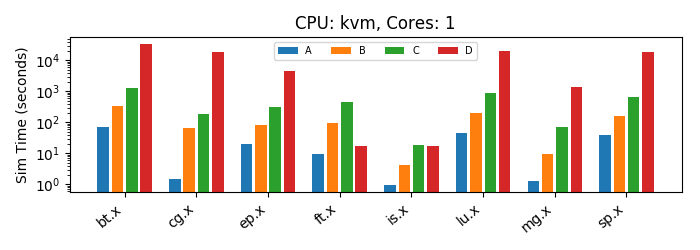

<IPython.core.display.Javascript object>


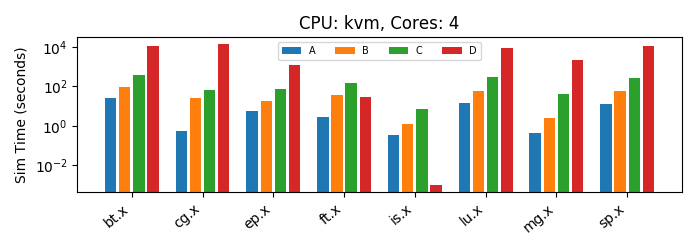

<IPython.core.display.Javascript object>


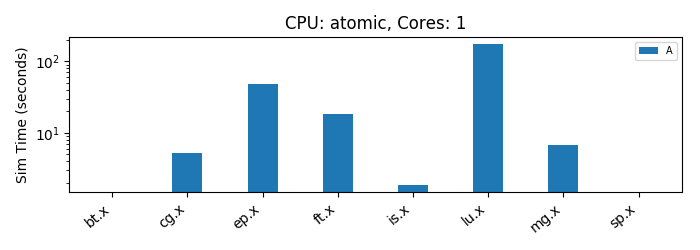

<IPython.core.display.Javascript object>


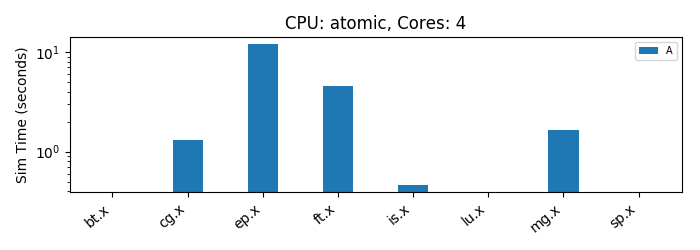

In [114]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_ty in ['kvm','atomic']:
    for core_cn in ['1','4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_ty,core_cn,'sim_time')
        plt.ylabel('Sim Time (seconds)')
        #plt.ylim(ymax = 1000, ymin = 0)
        plt.yscale( "log")
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_ty,core_cn))
        plt.tight_layout()


## Number of Instructions (in millions)

<IPython.core.display.Javascript object>


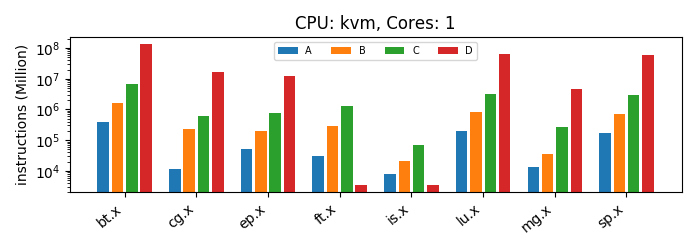

<IPython.core.display.Javascript object>


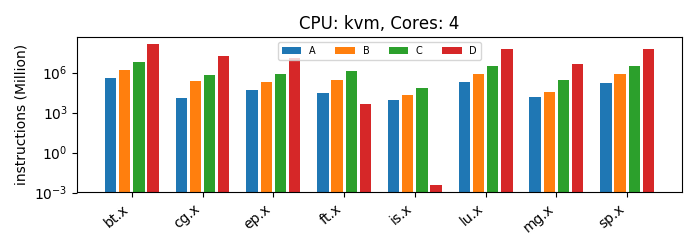

<IPython.core.display.Javascript object>


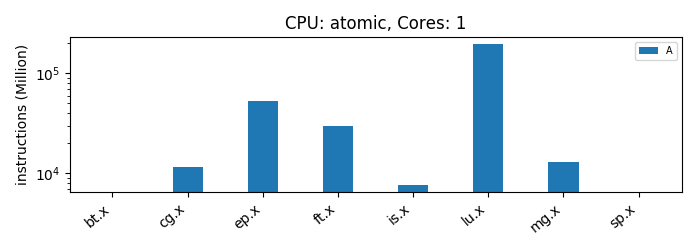

<IPython.core.display.Javascript object>


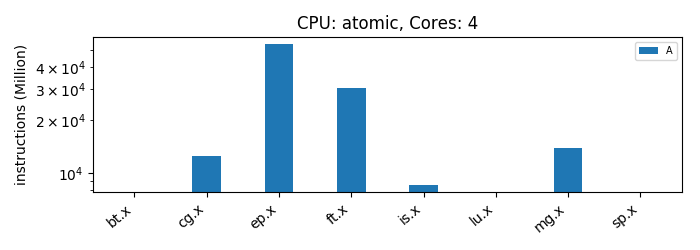

In [115]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_typ in ['kvm','atomic']:
    for core_cn in ['1','4']:#,'4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_typ,core_cn,'instructions')
        plt.ylabel('instructions (Million)')
        plt.yscale( "log")
        #plt.ylim(ymax = 7000000, ymin = 0)
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_typ,core_cn))
        plt.tight_layout()

## Host Time (minutes)

<IPython.core.display.Javascript object>


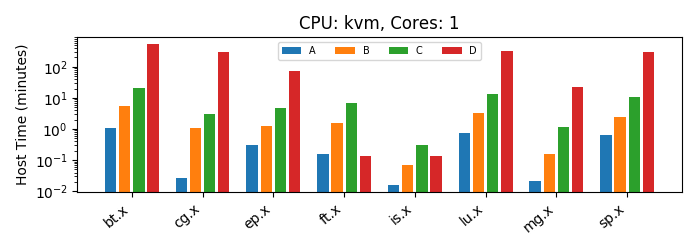

<IPython.core.display.Javascript object>


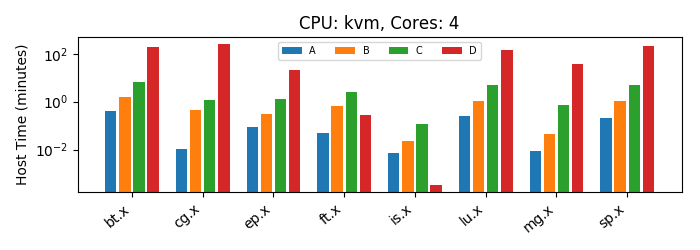

<IPython.core.display.Javascript object>


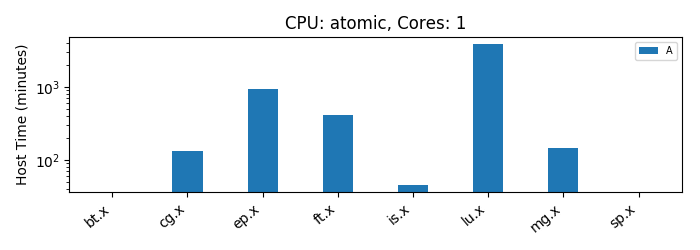

<IPython.core.display.Javascript object>


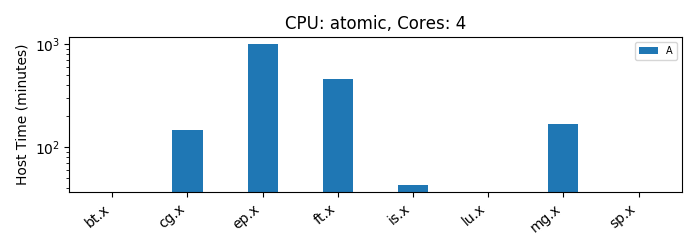

In [116]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_typ in ['kvm','atomic']:
    for core_cn in ['1','4']:#,'4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_typ,core_cn,'host_time')
        plt.ylabel('Host Time (minutes)')
        plt.yscale("log")
        #plt.ylim(ymax = 100, ymin = 0)
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_typ,core_cn))
        plt.tight_layout()